## **Deep Computer Vision with CNN**

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
  plt.imshow(image, cmap="gray", interpolation="nearest")
  plt.axis("off")

def plot_color_image(image):
  plt.imshow(image, interpolation="nearest")
  plt.axis("off")

### Convolution example

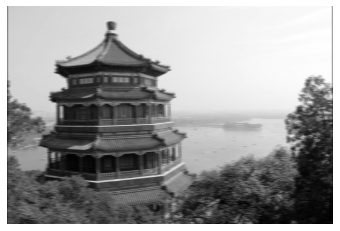

In [3]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, heigh, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 ##vertical line
filters[3, :, :, 1] = 1 ##Horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

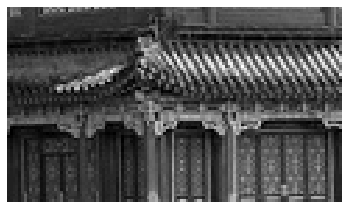

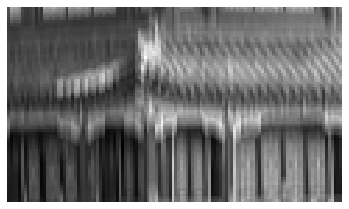

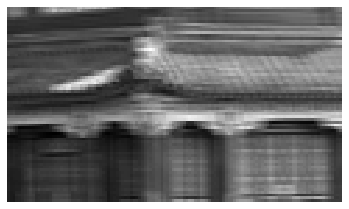

In [4]:
def crop(images):
  return images[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
  plot_image(crop(outputs[0, :, :, feature_map_index]))
  plt.show()

### Convolutional layer

In [5]:
## simply use keras layers
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

- Same padding returns output size of ceiling value of input divided by stride. so if stride = 1, input and ouput has the same size. Valid means no padding

### Pooling Layer

In [6]:
# max pooling
max_pool = keras.layers.MaxPool2D(pool_size=2)

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

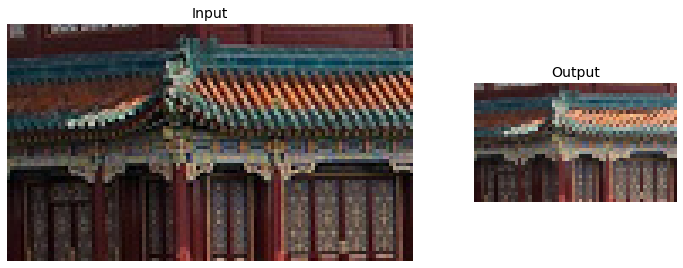

In [7]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [8]:
## depth wise pooling

class DepthMaxPool(keras.layers.Layer):
  def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
    super().__init__(**kwargs)
    if strides is None:
      strides = pool_size
    self.pool_size = pool_size
    self.strides = strides
    self.padding = padding
  def call(self, inputs):
    return tf.nn.max_pool(inputs,
                          ksize=(1, 1, 1, self.pool_size),
                          strides=(1, 1, 1, self.pool_size),
                          padding=self.padding)

In [9]:
depth_pool = DepthMaxPool(3)
depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

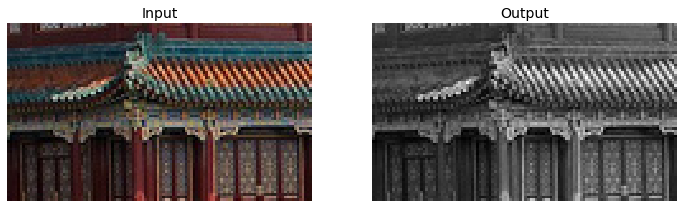

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

In [11]:
## Average pooling
avg_pool = keras.layers.AvgPool2D(pool_size=2)

output_avg = avg_pool(cropped_images)

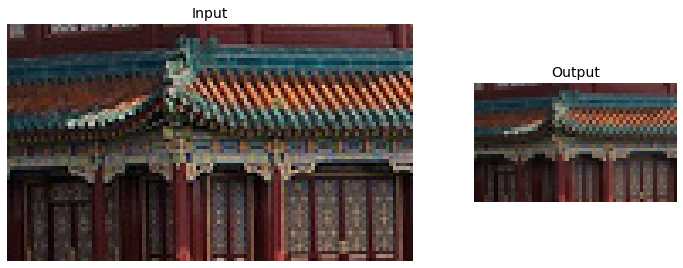

In [12]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Fashion MNIST with CNN

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True)
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std


4423680/4422102 [==============================] - 0s 0us/step


In [14]:
# into 3D object
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [15]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation="relu", padding="SAME")

model = keras.models.Sequential([
      DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
      keras.layers.MaxPooling2D(pool_size=2),
      DefaultConv2D(filters=128),
      DefaultConv2D(filters=128),
      keras.layers.MaxPooling2D(pool_size=2),
      DefaultConv2D(filters=256),
      DefaultConv2D(filters=256),
      keras.layers.MaxPooling2D(pool_size=2),
      keras.layers.Flatten(),
      keras.layers.Dense(units=128, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(units=64, activation="relu"),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(units=10, activation="softmax")
])

In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # lets say they are new
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 784s 455ms/step - loss: 0.9851 - accuracy: 0.6542 - val_loss: 0.3778 - val_accuracy: 0.8628
Epoch 2/10
1719/1719 [==============================] - 781s 454ms/step - loss: 0.4418 - accuracy: 0.8539 - val_loss: 0.3427 - val_accuracy: 0.8776
Epoch 3/10
1719/1719 [==============================] - 786s 457ms/step - loss: 0.3721 - accuracy: 0.8779 - val_loss: 0.3168 - val_accuracy: 0.8876
Epoch 4/10
1719/1719 [==============================] - 775s 451ms/step - loss: 0.3334 - accuracy: 0.8890 - val_loss: 0.3121 - val_accuracy: 0.8912
Epoch 5/10
1719/1719 [==============================] - 773s 450ms/step - loss: 0.3096 - accuracy: 0.8957 - val_loss: 0.2860 - val_accuracy: 0.8920
Epoch 6/10
1719/1719 [==============================] - 769s 448ms/step - loss: 0.2925 - accuracy: 0.9008 - val_loss: 0.2868 - val_accuracy: 0.9048
Epoch 7/10
1719/1719 [==============================] - 765s 445ms/step - loss: 0.2730 - accuracy: 0.9062 - val_

### ResNet-34

In [16]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [17]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

### Using pretrained model

In [19]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 1s 0us/step


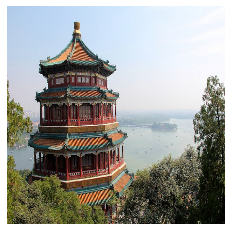

In [20]:
## preprocessing image
### resizing
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


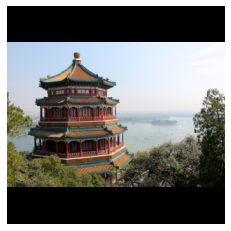

In [21]:
### padding
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

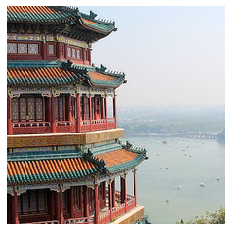

In [22]:
### cropped
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

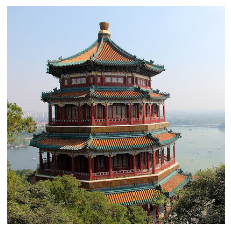

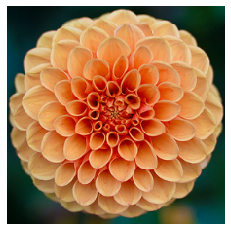

In [23]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0,1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [24]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

Y_proba.shape

(2, 1000)

In [25]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print("Image #{}".format(image_index))
  for class_id, name, y_proba in top_K[image_index]:
    print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba*100))

40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%
Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%


### Pretrained Models for Transfer Learning

In [26]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [27]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [28]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [29]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [30]:
n_classes = info.features["label"].num_classes

In [31]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [32]:
## load data into test, valid, train
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

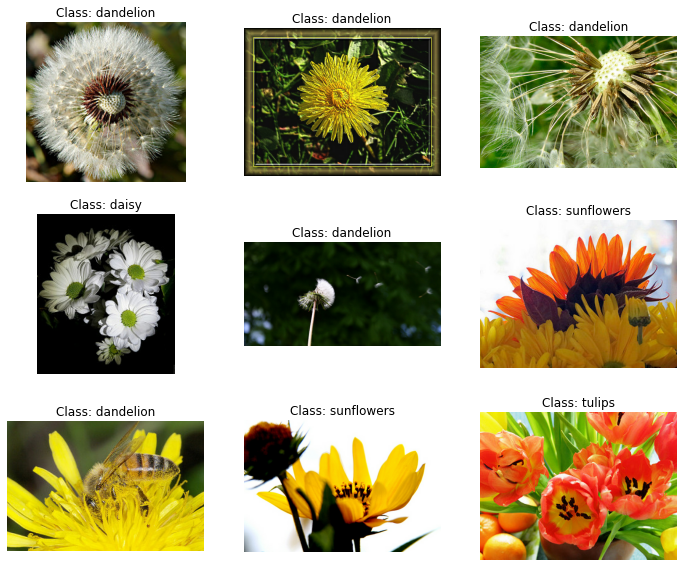

In [33]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  plt.title("Class: {}".format(class_names[label]))
  plt.axis("off")

plt.show()

In [34]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [35]:
# some data augmentations
def central_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]])
  top_crop = (shape[0] - min_dim) // 4
  bottom_crop = shape[0] - top_crop
  left_crop = (shape[1] - min_dim) // 4
  right_crop = shape[1] - left_crop
  return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
  return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
  if randomize:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
  else:
    cropped_image = central_crop(image)
  resized_image = tf.image.resize(cropped_image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

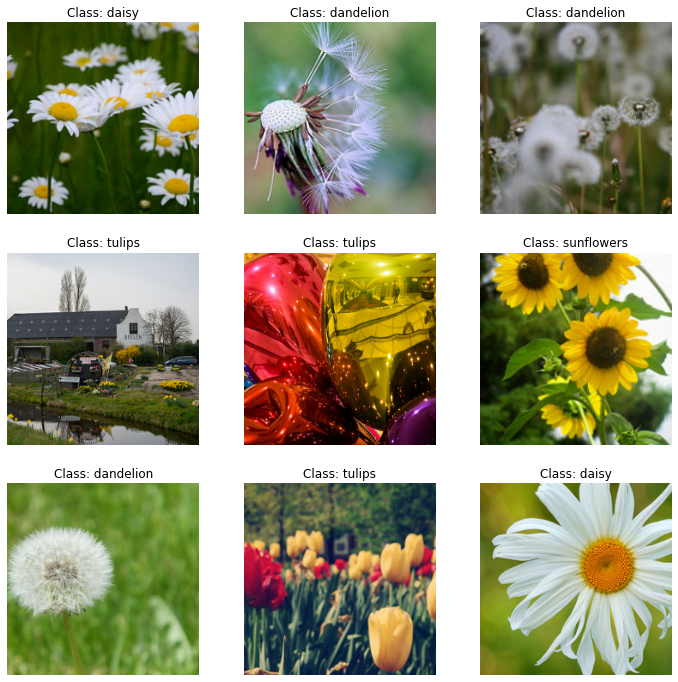

In [36]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [37]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [38]:
for index, layer in enumerate(base_model.layers):
  print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_46
13 block2_pool
14 batch_normalization_40
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_47
23 block3_pool
24 batch_normalization_41
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_48
33 block4_pool
34 batch_normalization_42
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [80]:
# fist train the last layer with other layers trainable=False
for layer in base_model.layers:
  layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data = valid_set,
                    validation_steps = int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 663s 8s/step - loss: 1.5273 - accuracy: 0.6994 - val_loss: 1.1621 - val_accuracy: 0.8254
Epoch 2/5
86/86 [==============================] - 653s 8s/step - loss: 0.5307 - accuracy: 0.8925 - val_loss: 0.7847 - val_accuracy: 0.8474
Epoch 3/5
86/86 [==============================] - 652s 8s/step - loss: 0.4497 - accuracy: 0.9016 - val_loss: 0.6955 - val_accuracy: 0.8658
Epoch 4/5
86/86 [==============================] - 655s 8s/step - loss: 0.2452 - accuracy: 0.9317 - val_loss: 0.6675 - val_accuracy: 0.8695
Epoch 5/5
86/86 [==============================] - 655s 8s/step - loss: 0.1801 - accuracy: 0.9543 - val_loss: 0.6735 - val_accuracy: 0.8676


In [82]:
# now change to train = true and retrain
for layer in base_model.layers:
  layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 2519s 29s/step - loss: 0.1466 - accuracy: 0.9535 - val_loss: 0.4207 - val_accuracy: 0.8805
Epoch 2/5
86/86 [==============================] - 2499s 29s/step - loss: 0.0682 - accuracy: 0.9754 - val_loss: 0.2992 - val_accuracy: 0.8915
Epoch 3/5
86/86 [==============================] - 2465s 29s/step - loss: 0.0453 - accuracy: 0.9829 - val_loss: 0.2799 - val_accuracy: 0.9154
Epoch 4/5
86/86 [==============================] - 2460s 29s/step - loss: 0.0302 - accuracy: 0.9895 - val_loss: 0.2883 - val_accuracy: 0.9246
Epoch 5/5
86/86 [==============================] - 2454s 29s/step - loss: 0.0344 - accuracy: 0.9909 - val_loss: 0.2517 - val_accuracy: 0.9210


### Classification and Localization

In [40]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input, outputs=[class_output, loc_output])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=["accuracy"])

In [41]:
def add_random_bounding_boxes(images, labels):
  fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
  return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [43]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 138s 26s/step - loss: 1.3386 - dense_7_loss: 1.6123 - dense_8_loss: 0.2436 - dense_7_accuracy: 0.2376 - dense_8_accuracy: 0.2549
Epoch 2/2
5/5 [==============================] - 132s 26s/step - loss: 1.1924 - dense_7_loss: 1.4384 - dense_8_loss: 0.2086 - dense_7_accuracy: 0.3493 - dense_8_accuracy: 0.2005


### Mean Average Precision(mAP)

In [44]:
def maximum_precisions(precisions):
  return np.flip(np.maximum.accumulate(np.flip(precisions)))

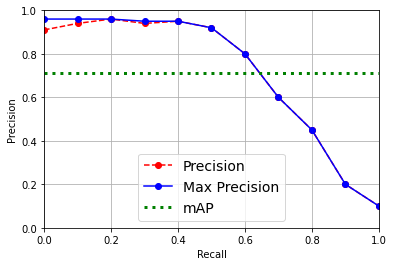

In [45]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

### Upscaling

In [46]:
# transpose convolutions
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

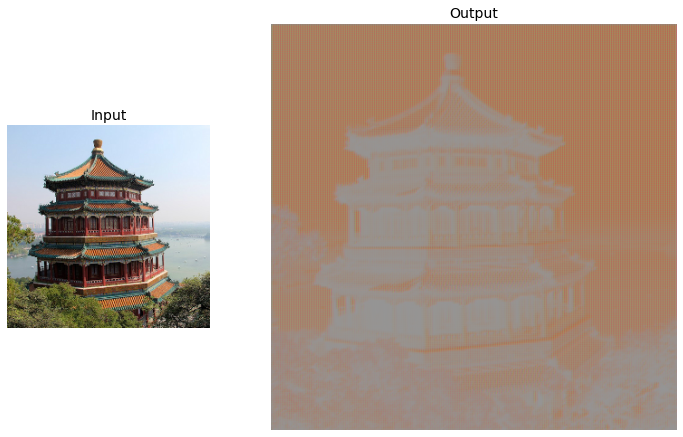

In [47]:
def normalize(X):
  return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0 ,1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")
ax2.axis("off")
plt.show()

### High Accuracy CNN for MNIST

In [48]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11493376/11490434 [==============================] - 0s 0us/step


In [49]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 209s 121ms/step - loss: 0.3697 - accuracy: 0.8814 - val_loss: 0.0527 - val_accuracy: 0.9858
Epoch 2/10
1719/1719 [==============================] - 206s 120ms/step - loss: 0.0860 - accuracy: 0.9741 - val_loss: 0.0473 - val_accuracy: 0.9876
Epoch 3/10
1719/1719 [==============================] - 205s 119ms/step - loss: 0.0623 - accuracy: 0.9811 - val_loss: 0.0447 - val_accuracy: 0.9876
Epoch 4/10
1719/1719 [==============================] - 208s 121ms/step - loss: 0.0515 - accuracy: 0.9838 - val_loss: 0.0327 - val_accuracy: 0.9926
Epoch 5/10
1719/1719 [==============================] - 206s 120ms/step - loss: 0.0427 - accuracy: 0.9864 - val_loss: 0.0341 - val_accuracy: 0.9910
Epoch 6/10
1719/1719 [==============================] - 206s 120ms/step - loss: 0.0382 - accuracy: 0.9886 - val_loss: 0.0373 - val_accuracy: 0.9914
Epoch 7/10
1719/1719 [==============================] - 209s 122ms/step - loss: 0.0314 - accuracy: 0.9895 - val_

[0.02674758993089199, 0.9919999837875366]